In [2]:
from llm_manager import get_llm_instance
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import PromptTemplate
from typing import TypedDict
from langgraph.graph import StateGraph, START, END

F:\GenAI\LangGraph_OpenSource\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 1. LLM

In [3]:
llm = get_llm_instance()

Initializing LLM: mistralai/Mistral-7B-Instruct-v0.2...


`torch_dtype` is deprecated! Use `dtype` instead!
Loading checkpoint shards: 100%|██████████| 3/3 [00:06<00:00,  2.30s/it]
Device set to use cuda


LLM initialization complete for mistralai/Mistral-7B-Instruct-v0.2.


F:\GenAI\LangGraph_OpenSource\llm_manager.py:29: UserWarning: LLMManager is already initialized. Returning existing instance.
  warnings.warn("LLMManager is already initialized. Returning existing instance.")


# 2. Output Parser

In [4]:
output_parser = StrOutputParser()

# 3. State Define

In [5]:
class EssayEvaluationState(TypedDict):
    essay: str
    language_evaluation: str
    analytical_evaluation: str
    cot_evaluation: str
    overall_evaluation: str


# 4. Node Define

In [6]:
def language_evaluation_function(state: EssayEvaluationState):
    essay = state['essay']
    
    prompt = PromptTemplate(
        template="""
        Evaluate the essay’s \n 
        {essay}
         \n language quality. Comment on grammar accuracy, vocabulary richness, sentence structure variety, tone appropriateness, and overall fluency. Provide specific examples where the language is strong or needs improvement.
        """,input_variables=['essay']
    )
    
    chain = prompt | llm | output_parser
    
    language_evaluation = chain.invoke({"essay": essay})
    return {"language_evaluation" : language_evaluation}

In [7]:
def analytical_evaluation_function(state: EssayEvaluationState):
    essay = state['essay']
    
    prompt = PromptTemplate( 
        template=""" Analyze how well the essay \n {essay} \n presents logical reasoning and critical thinking. Evaluate the strength of arguments, relevance of evidence, depth of analysis, and ability to address counterarguments. Provide clear feedback on where the analysis succeeds and where it could be strengthened.
    """,input_variables=['essay']
    )
    
    chain = prompt | llm | output_parser
    
    analytical_evaluation = chain.invoke({"essay": essay})
    return {"analytical_evaluation" : analytical_evaluation}

In [8]:
def cot_evaluation_function(state: EssayEvaluationState):
    essay = state['essay']
    
    prompt = PromptTemplate(
        template="""Assess the clarity and coherence of ideas in the essay \n {essay} \n. Evaluate organization, transitions between paragraphs, logical flow, focus of the thesis, and consistency of the main message. Highlight specific sections where clarity shines or breaks down.
        """,input_variables=['essay']
    )
    
    chain = prompt | llm | output_parser
    
    cot_evaluation = chain.invoke({"essay": essay})
    return {"cot_evaluation" : cot_evaluation}

In [9]:
def overall_evaluation_function(state: EssayEvaluationState):
    
    language_evaluation = state['language_evaluation']
    analytical_evaluation = state['analytical_evaluation']
    cot_evaluation = state['cot_evaluation']
    
    prompt = PromptTemplate(
        template="""Provide an overall evaluation of the essay by summarizing its language quality: \n {language_evaluation} \n, analytical strength: \n {analytical_evaluation} \n, and clarity of thought: {cot_evaluation}. Give a concise but comprehensive final assessment that highlights the essay’s major strengths, key weaknesses, and actionable recommendations for improvement.
        """,input_variables=['language_evaluation', 'analytical_evaluation', 'cot_evaluation']
    )
    
    chain = prompt | llm | output_parser
    
    overall_evaluation = chain.invoke({"language_evaluation":language_evaluation,"analytical_evaluation":analytical_evaluation,"cot_evaluation":cot_evaluation})
    return {"overall_evaluation" : overall_evaluation}

# 5. Graph Design

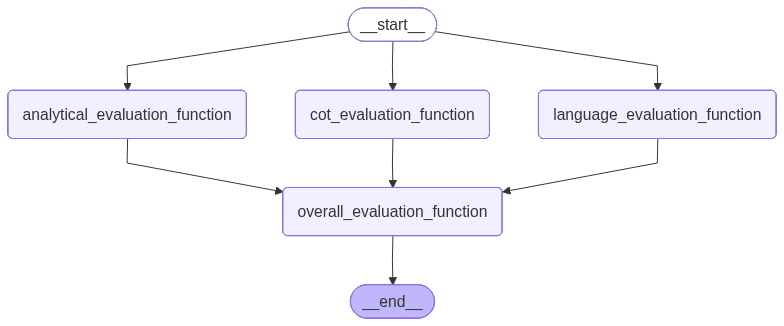

In [11]:
graph = StateGraph(EssayEvaluationState)

graph.add_node("language_evaluation_function", language_evaluation_function)
graph.add_node("analytical_evaluation_function", analytical_evaluation_function)
graph.add_node("cot_evaluation_function", cot_evaluation_function)
graph.add_node("overall_evaluation_function", overall_evaluation_function)

graph.add_edge(START,'language_evaluation_function')
graph.add_edge(START,'analytical_evaluation_function')
graph.add_edge(START,'cot_evaluation_function')

graph.add_edge('language_evaluation_function', 'overall_evaluation_function')
graph.add_edge('analytical_evaluation_function', 'overall_evaluation_function')
graph.add_edge('cot_evaluation_function', 'overall_evaluation_function')

graph.add_edge('overall_evaluation_function', END)

workflow = graph.compile()
workflow

# 6. Compile

In [12]:
essay = """The Role of Artificial Intelligence in the World

Artificial Intelligence (AI) has rapidly become one of the most transformative forces of the 21st century. It refers to the ability of machines and computer systems to perform tasks that typically require human intelligence, such as learning, reasoning, decision-making, and problem-solving. Today, AI plays a central role in shaping industries, influencing societies, and redefining how humans interact with technology. Its impact is vast, extending from healthcare and education to business, communication, and even global governance.

AI in Everyday Life

AI is already deeply embedded in daily routines, often without people realizing it. Recommendation systems on platforms like YouTube, Netflix, and Spotify personalize entertainment choices, while navigation apps like Google Maps optimize travel routes using real-time traffic data. Virtual assistants such as Siri, Alexa, and Google Assistant have made voice-driven interaction with technology commonplace. These examples highlight how AI improves convenience, saves time, and enhances user experiences in subtle but significant ways.

AI in Healthcare

One of the most promising applications of AI lies in healthcare. AI systems can analyze massive datasets of medical images, records, and research to detect diseases earlier and more accurately than traditional methods. For instance, AI-powered diagnostic tools can identify cancers or heart conditions with remarkable precision. Moreover, AI supports drug discovery by predicting how molecules will interact, significantly reducing research time and costs. During the COVID-19 pandemic, AI models played a crucial role in tracking the spread of the virus and assisting in vaccine development.

AI in Business and Economy

Businesses around the globe leverage AI to improve efficiency, reduce costs, and enhance customer satisfaction. Automation, powered by AI, has transformed manufacturing processes, while AI-driven analytics help companies make informed decisions by uncovering hidden patterns in data. Customer service has also been revolutionized by AI chatbots and virtual agents, offering 24/7 support and handling routine inquiries. However, the rise of AI has also fueled debates about job displacement, as some roles are replaced by machines, creating the urgent need for reskilling and adaptation in the workforce.

AI in Education

In education, AI is reshaping the way students learn and teachers instruct. Adaptive learning platforms tailor lessons to individual needs, ensuring that students progress at their own pace. AI tutors provide extra support for learners outside classrooms, while automated grading systems save teachers valuable time. This personalization of education holds the potential to bridge learning gaps and make quality education more accessible worldwide.

Ethical and Social Considerations

Despite its many benefits, AI raises complex ethical, legal, and social questions. Issues such as data privacy, algorithmic bias, and the misuse of AI for surveillance or autonomous weapons are pressing concerns. Furthermore, the concentration of AI power among a few corporations and countries creates global imbalances. Ensuring responsible AI development requires international cooperation, transparent governance, and strict ethical guidelines.

Conclusion

The role of AI in the world is multifaceted and ever-expanding. It has the power to solve humanity’s greatest challenges—such as climate change, healthcare access, and food security—while also introducing risks that demand careful management. The future of AI will be shaped not only by technological breakthroughs but also by the values and policies societies choose to adopt. Ultimately, AI should be viewed as a tool to augment human potential, not replace it, guiding us toward a future where technology and humanity thrive together.

"""

In [13]:
initial_state = {'essay': essay}
final_state = workflow.invoke(initial_state)
print(final_state)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


{'essay': 'The Role of Artificial Intelligence in the World\n\nArtificial Intelligence (AI) has rapidly become one of the most transformative forces of the 21st century. It refers to the ability of machines and computer systems to perform tasks that typically require human intelligence, such as learning, reasoning, decision-making, and problem-solving. Today, AI plays a central role in shaping industries, influencing societies, and redefining how humans interact with technology. Its impact is vast, extending from healthcare and education to business, communication, and even global governance.\n\nAI in Everyday Life\n\nAI is already deeply embedded in daily routines, often without people realizing it. Recommendation systems on platforms like YouTube, Netflix, and Spotify personalize entertainment choices, while navigation apps like Google Maps optimize travel routes using real-time traffic data. Virtual assistants such as Siri, Alexa, and Google Assistant have made voice-driven interact

In [14]:
final_state['language_evaluation']

'<s> [INST] \n        Evaluate the essay’s \n \n        The Role of Artificial Intelligence in the World\n\nArtificial Intelligence (AI) has rapidly become one of the most transformative forces of the 21st century. It refers to the ability of machines and computer systems to perform tasks that typically require human intelligence, such as learning, reasoning, decision-making, and problem-solving. Today, AI plays a central role in shaping industries, influencing societies, and redefining how humans interact with technology. Its impact is vast, extending from healthcare and education to business, communication, and even global governance.\n\nAI in Everyday Life\n\nAI is already deeply embedded in daily routines, often without people realizing it. Recommendation systems on platforms like YouTube, Netflix, and Spotify personalize entertainment choices, while navigation apps like Google Maps optimize travel routes using real-time traffic data. Virtual assistants such as Siri, Alexa, and Goo

In [15]:
final_state['analytical_evaluation']

'<s> [INST]  Analyze how well the essay \n The Role of Artificial Intelligence in the World\n\nArtificial Intelligence (AI) has rapidly become one of the most transformative forces of the 21st century. It refers to the ability of machines and computer systems to perform tasks that typically require human intelligence, such as learning, reasoning, decision-making, and problem-solving. Today, AI plays a central role in shaping industries, influencing societies, and redefining how humans interact with technology. Its impact is vast, extending from healthcare and education to business, communication, and even global governance.\n\nAI in Everyday Life\n\nAI is already deeply embedded in daily routines, often without people realizing it. Recommendation systems on platforms like YouTube, Netflix, and Spotify personalize entertainment choices, while navigation apps like Google Maps optimize travel routes using real-time traffic data. Virtual assistants such as Siri, Alexa, and Google Assistant

In [16]:
final_state['cot_evaluation']

'<s> [INST] Assess the clarity and coherence of ideas in the essay \n The Role of Artificial Intelligence in the World\n\nArtificial Intelligence (AI) has rapidly become one of the most transformative forces of the 21st century. It refers to the ability of machines and computer systems to perform tasks that typically require human intelligence, such as learning, reasoning, decision-making, and problem-solving. Today, AI plays a central role in shaping industries, influencing societies, and redefining how humans interact with technology. Its impact is vast, extending from healthcare and education to business, communication, and even global governance.\n\nAI in Everyday Life\n\nAI is already deeply embedded in daily routines, often without people realizing it. Recommendation systems on platforms like YouTube, Netflix, and Spotify personalize entertainment choices, while navigation apps like Google Maps optimize travel routes using real-time traffic data. Virtual assistants such as Siri, 

In [17]:
final_state['overall_evaluation']

'<s> [INST] Provide an overall evaluation of the essay by summarizing its language quality: \n <s> [INST] \n        Evaluate the essay’s \n \n        The Role of Artificial Intelligence in the World\n\nArtificial Intelligence (AI) has rapidly become one of the most transformative forces of the 21st century. It refers to the ability of machines and computer systems to perform tasks that typically require human intelligence, such as learning, reasoning, decision-making, and problem-solving. Today, AI plays a central role in shaping industries, influencing societies, and redefining how humans interact with technology. Its impact is vast, extending from healthcare and education to business, communication, and even global governance.\n\nAI in Everyday Life\n\nAI is already deeply embedded in daily routines, often without people realizing it. Recommendation systems on platforms like YouTube, Netflix, and Spotify personalize entertainment choices, while navigation apps like Google Maps optimi